In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lifelines
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
pd.options.display.max_columns = None
pd.set_option('display.max_rows', 200)
plt.rcParams['figure.figsize']=(15,7)

In [43]:
from lifelines.datasets import load_dd
data = load_dd()
data.head()

,ctryname,cowcode2,politycode,un_region_name,un_continent_name,ehead,leaderspellreg,democracy,regime,start_year,duration,observed
0,Afghanistan,700,700.0,Southern Asia,Asia,Mohammad Zahir Shah,Mohammad Zahir Shah.Afghanistan.1946.1952.Mona...,Non-democracy,Monarchy,1946,7,1
1,Afghanistan,700,700.0,Southern Asia,Asia,Sardar Mohammad Daoud,Sardar Mohammad Daoud.Afghanistan.1953.1962.Ci...,Non-democracy,Civilian Dict,1953,10,1
2,Afghanistan,700,700.0,Southern Asia,Asia,Mohammad Zahir Shah,Mohammad Zahir Shah.Afghanistan.1963.1972.Mona...,Non-democracy,Monarchy,1963,10,1
3,Afghanistan,700,700.0,Southern Asia,Asia,Sardar Mohammad Daoud,Sardar Mohammad Daoud.Afghanistan.1973.1977.Ci...,Non-democracy,Civilian Dict,1973,5,0
4,Afghanistan,700,700.0,Southern Asia,Asia,Nur Mohammad Taraki,Nur Mohammad Taraki.Afghanistan.1978.1978.Civi...,Non-democracy,Civilian Dict,1978,1,0


# non parametric estimation of survival function

In [14]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

In [15]:
kmf.fit(data.duration,event_observed=data.observed)

<lifelines.KaplanMeierFitter: fitted with 1808 observations, 340 censored>

Text(0.5, 1.0, 'Survival function of political regimes')

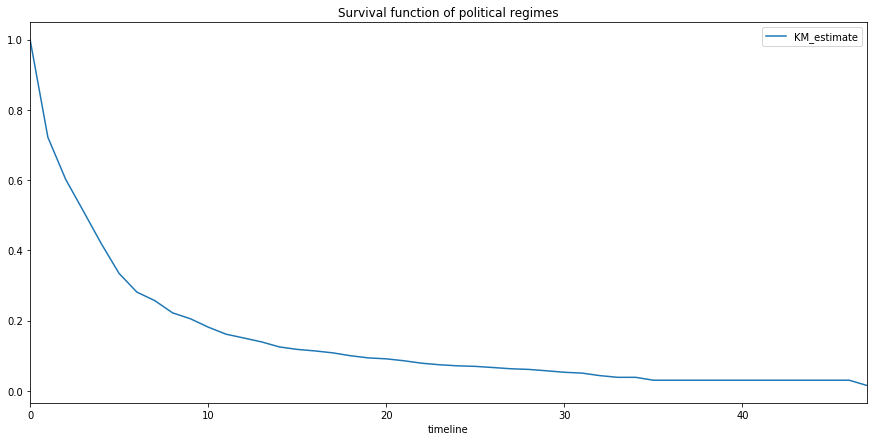

In [16]:
kmf.survival_function_.plot()
plt.title('Survival function of political regimes')

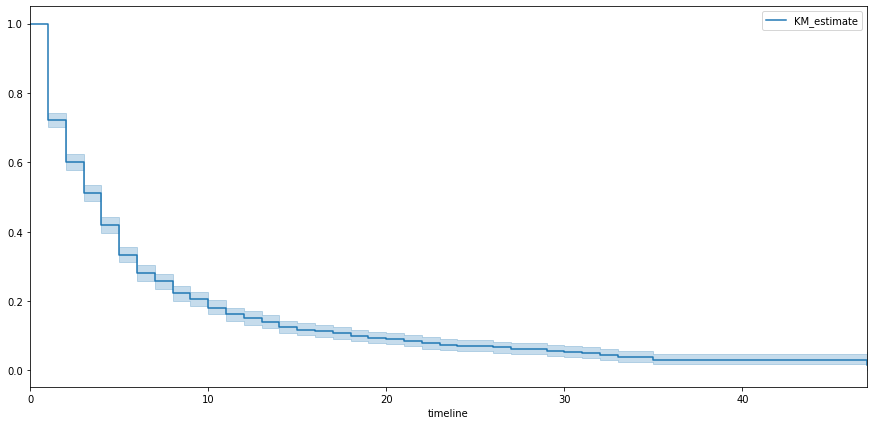

In [17]:
kmf.plot()

In [18]:
kmf.median_

4.0

In [20]:
T=data.duration
E=data.observed

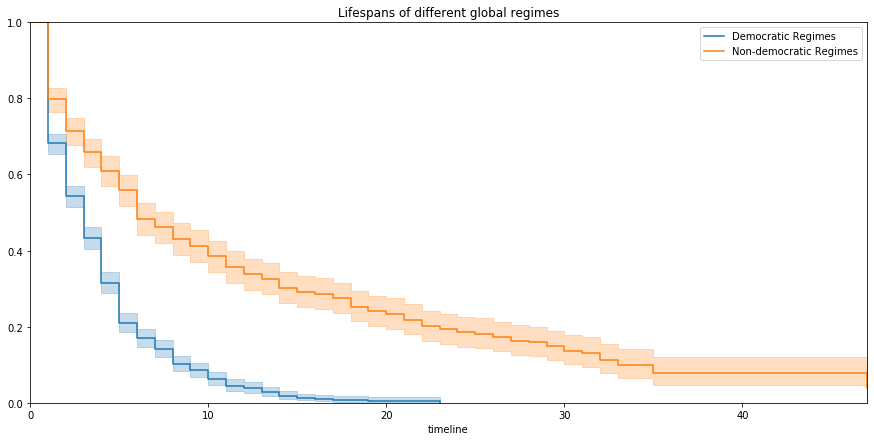

In [21]:
ax = plt.subplot(111)
dem = (data["democracy"] == "Democracy")
kmf.fit(T[dem], event_observed=E[dem], label="Democratic Regimes")
kmf.plot(ax=ax)
kmf.fit(T[~dem], event_observed=E[~dem], label="Non-democratic Regimes")
kmf.plot(ax=ax)
plt.ylim(0, 1);
plt.title("Lifespans of different global regimes");

Median survival time of democratic: 3.0
Median survival time of non-democratic: 6.0


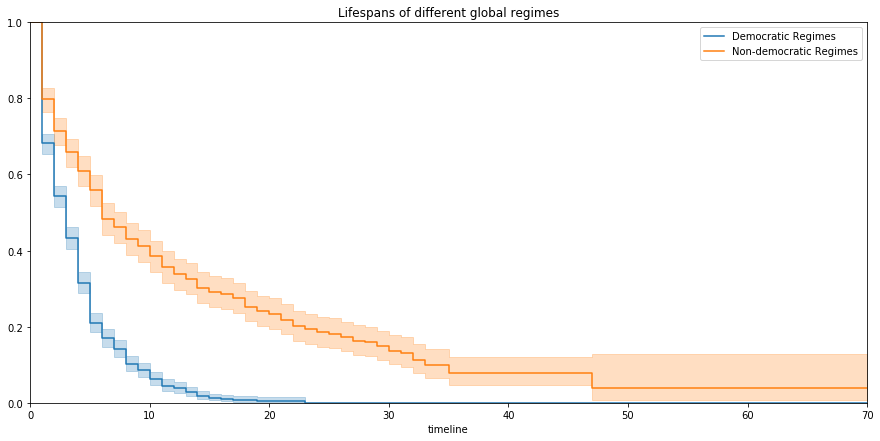

In [29]:
ax = plt.subplot(111)

t = np.linspace(0, 70, 71)
kmf.fit(T[dem], event_observed=E[dem], timeline=t, label="Democratic Regimes")
ax = kmf.plot(ax=ax)
print("Median survival time of democratic:", kmf.median_)

kmf.fit(T[~dem], event_observed=E[~dem], timeline=t, label="Non-democratic Regimes")
ax = kmf.plot(ax=ax)
print("Median survival time of non-democratic:", kmf.median_)

plt.ylim(0, 1)
plt.title("Lifespans of different global regimes");


In [31]:
from lifelines.statistics import logrank_test

results = logrank_test(T[dem], T[~dem], E[dem], E[~dem], alpha=.99)

results.print_summary()

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99

---
 test_statistic      p  -log2(p)
         260.47 <0.005    192.23


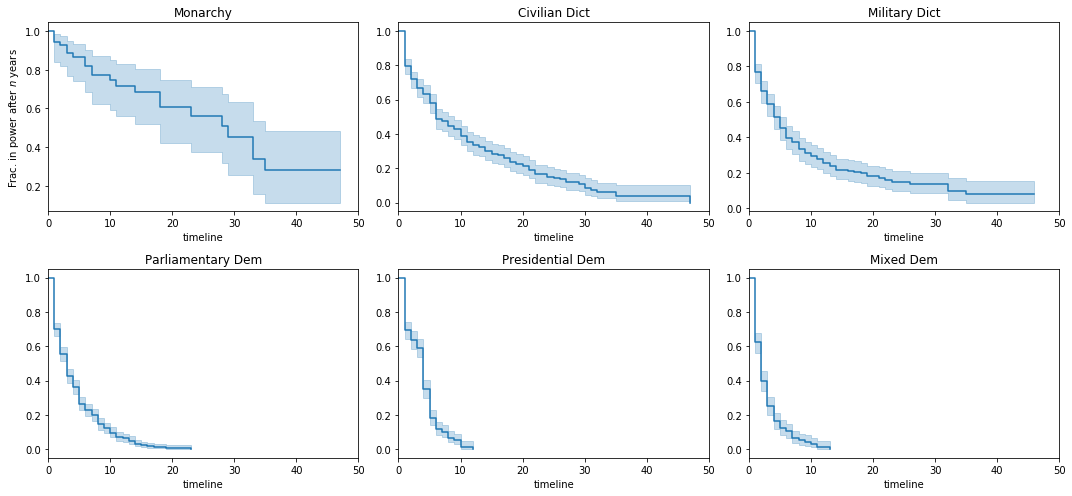

In [30]:
regime_types = data['regime'].unique()

for i, regime_type in enumerate(regime_types):
    ax = plt.subplot(2, 3, i + 1)

    ix = data['regime'] == regime_type
    kmf.fit(T[ix], E[ix], label=regime_type)
    kmf.plot(ax=ax, legend=False)

    plt.title(regime_type)
    plt.xlim(0, 50)

    if i==0:
        plt.ylabel('Frac. in power after $n$ years')

plt.tight_layout()

# Nonparametric estimation of hazard function / cumulative hazard function

In [44]:
T = data["duration"]
E = data["observed"]

In [45]:
from lifelines import NelsonAalenFitter
naf = NelsonAalenFitter()

naf.fit(T,event_observed=E)

<lifelines.NelsonAalenFitter: fitted with 1808 observations, 340 censored>

In [46]:
naf.cumulative_hazard_.head()

,NA_estimate
timeline,
0.0,0.000000
1.0,0.325912
2.0,0.507356
3.0,0.671251
4.0,0.869867


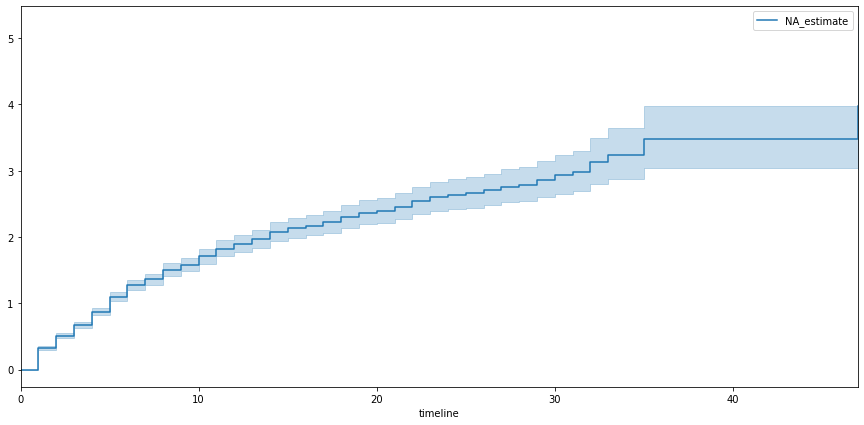

In [47]:
naf.plot()

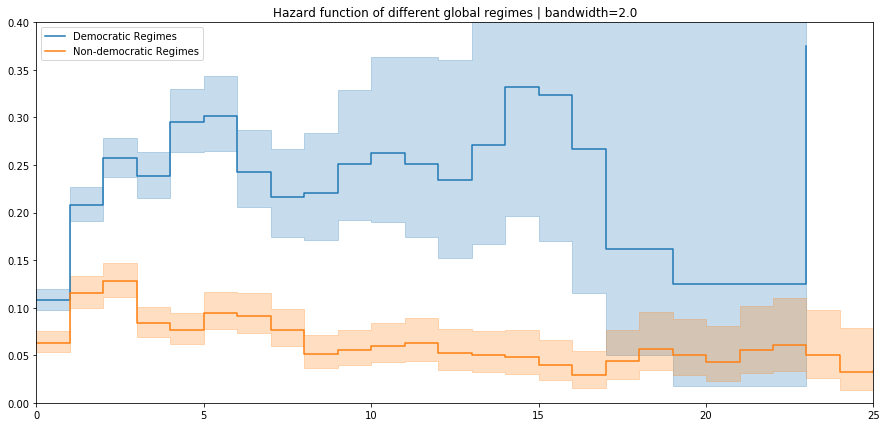

In [48]:
bandwidth = 2

naf.fit(T[dem], event_observed=E[dem], label="Democratic Regimes")
ax = naf.plot_hazard(bandwidth=bandwidth)

naf.fit(T[~dem], event_observed=E[~dem], label="Non-democratic Regimes")
naf.plot_hazard(ax=ax, bandwidth=bandwidth)

plt.title("Hazard function of different global regimes | bandwidth=%.1f" % bandwidth);
plt.ylim(0, 0.4)
plt.xlim(0, 25);

# Parametric estimation of hazzard function

- weibul
- lognormal
- exponential
- gamma
- ...

Fitting methods probably MLE. Seen GMM elsewhere.

<lifelines.WeibullFitter: fitted with 1808 observations, 340 censored>
number of subjects = 1808
  number of events = 1468
    log-likelihood = -4144.28
        hypothesis = lambda_ != 1, rho_ != 1

---
         coef  se(coef)  lower 0.95  upper 0.95      p  -log2(p)
lambda_  6.11      0.17        5.77        6.45 <0.005    642.95
rho_     0.94      0.02        0.91        0.98 <0.005      9.45
<lifelines.GeneralizedGammaFitter: fitted with 1808 observations, 340 censored>
number of subjects = 1808
  number of events = 1468
    log-likelihood = -3455.38
        hypothesis = mu_ != 0, ln_sigma_ != 0, lambda_ != 1

---
            coef  se(coef)  lower 0.95  upper 0.95      p  -log2(p)
mu_         0.01      0.00        0.00        0.01   0.02      5.74
ln_sigma_  -2.37      0.08       -2.52       -2.22 <0.005    659.44
lambda_   -14.51      1.08      -16.63      -12.39 <0.005    152.52


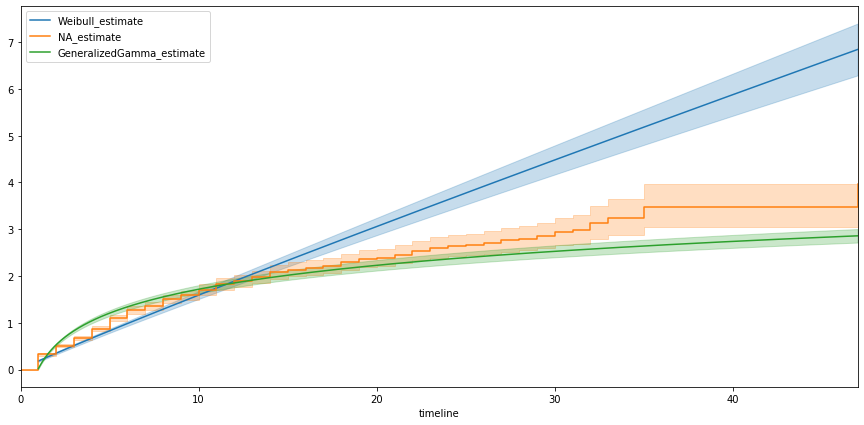

In [58]:
from lifelines import WeibullFitter,GeneralizedGammaFitter
from lifelines.datasets import load_waltons


wf = WeibullFitter().fit(T, E)
naf= NelsonAalenFitter().fit(T,event_observed=E)
gamma = GeneralizedGammaFitter().fit(T, E)

wf.print_summary()
gamma.print_summary()
plt.figure()
ax=plt.gca()
wf.plot(ax=ax)
naf.plot(ax=ax)
gamma.plot(ax=ax)

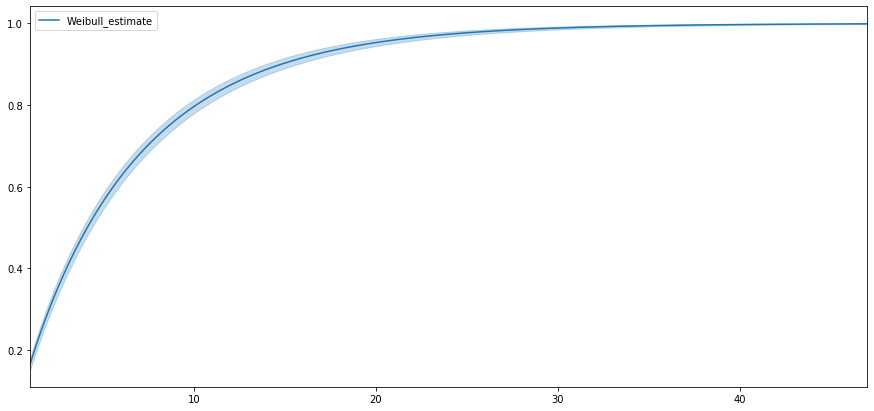

In [76]:
wf.plot_cumulative_density()

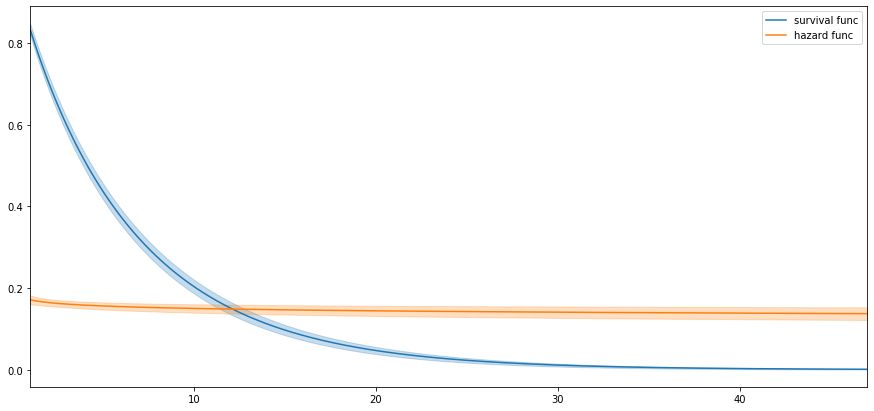

In [79]:
wf.plot_survival_function(label='survival func')
wf.plot_hazard(ax=plt.gca(),label='hazard func')

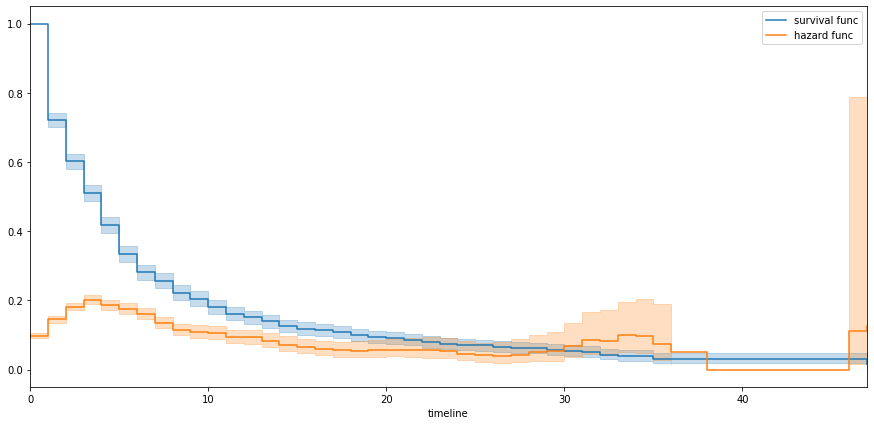

In [81]:
kmf.fit(data.duration,event_observed=data.observed).plot_survival_function(label='survival func')
naf.plot_hazard(ax=plt.gca(),bandwidth=3,label='hazard func')

- $f(t)$ - density of durations. Probability of when subject dies.
 
- $F(t)$ - distribution of durations - %ppl dead until this time. $ P(T \leq t)$

- Survival function - pravdepodobnost ze subjekt prezije dlhsie nez nejaky cas t $$ S(t) = P(T>t) $$ 
T - death event 

- hazard function - "rate" death eventu v danom okamziku, ak este nezomrel t $$ h(t) = \lim_{dt \to 0} \frac{P(t \leq T \leq t+dt | T>t)}{dt} $$
P( ... | T>t) - podmienena pravdep. ak este zije, lebo inak je to pochopitelne 

- cumulative hazard function - integral hazard function, suma pravdepodobnosti death eventu pred casom t, v podstate ak je =1 vsetko je mrtve
$$ H(t) = \int_{0}^{t} h(s) ds$$

# Left censoring

We know when death event occured, but necessarily when birth event occured.

In [82]:
from lifelines.datasets import load_nh4
df = load_nh4()[['NH4.Orig.mg.per.L', 'NH4.mg.per.L', 'Censored']]
print(df.head())

  NH4.Orig.mg.per.L  NH4.mg.per.L  Censored
1            <0.006         0.006      True
2            <0.006         0.006      True
3             0.006         0.006     False
4             0.016         0.016     False
5            <0.006         0.006      True


In [83]:
T, E = df['NH4.mg.per.L'], ~df['Censored']

kmf = KaplanMeierFitter()
kmf.fit_left_censoring(T, E)

<lifelines.KaplanMeierFitter: fitted with 102 observations, 46 censored>

          KM_estimate
timeline             
0.000        0.379897
0.006        0.401002
0.007        0.464319
0.008        0.478828
0.009        0.536868


Text(0.5, 0, 'Concentration of NH_4')

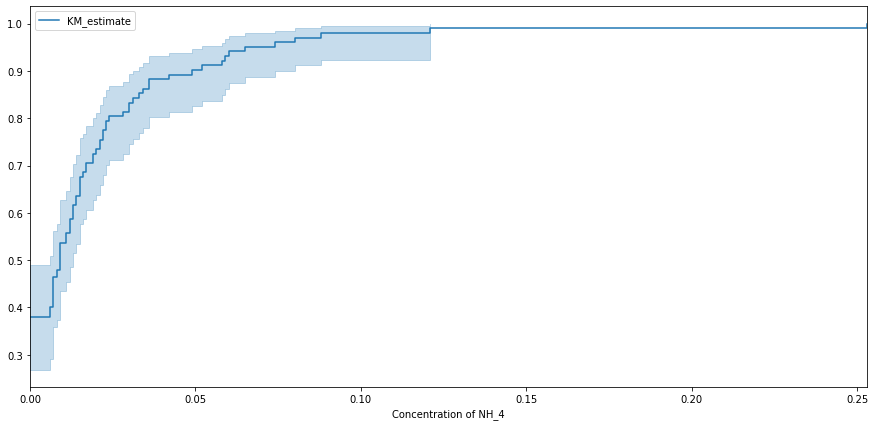

In [84]:
print(kmf.cumulative_density_.head())

kmf.plot() #will plot the CDF
plt.xlabel("Concentration of NH_4")

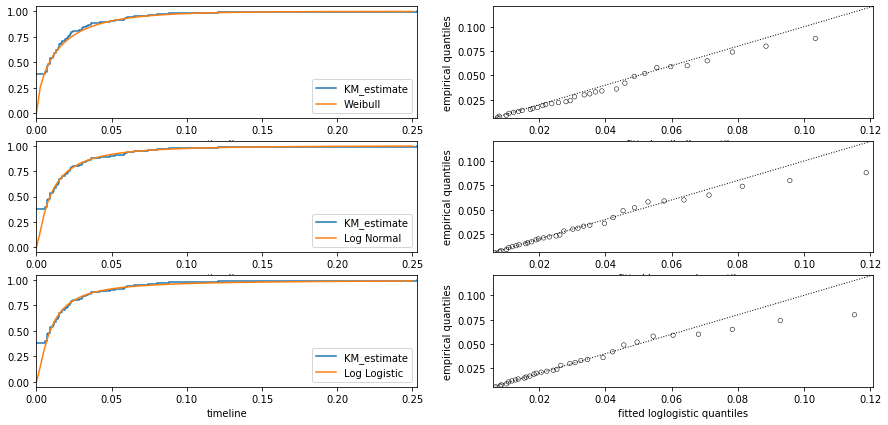

In [86]:
from lifelines import *
from lifelines.plotting import qq_plot

fig, axes = plt.subplots(3, 2)
timeline = np.linspace(0, 0.25, 100)

wf = WeibullFitter().fit_left_censoring(T, E, label="Weibull", timeline=timeline)
lnf = LogNormalFitter().fit_left_censoring(T, E, label="Log Normal", timeline=timeline)
lgf = LogLogisticFitter().fit_left_censoring(T, E, label="Log Logistic", timeline=timeline)

# plot what we just fit, along with the KMF estimate
kmf.plot_cumulative_density(ax=axes[0][0], ci_show=False)
wf.plot_cumulative_density(ax=axes[0][0], ci_show=False)
qq_plot(wf, ax=axes[0][1])

kmf.plot_cumulative_density(ax=axes[1][0], ci_show=False)
lnf.plot_cumulative_density(ax=axes[1][0], ci_show=False)
qq_plot(lnf, ax=axes[1][1])

kmf.plot_cumulative_density(ax=axes[2][0], ci_show=False)
lgf.plot_cumulative_density(ax=axes[2][0], ci_show=False)
qq_plot(lgf, ax=axes[2][1])